# JIRA Sprint Data
## Random Forest and XGB Regressors
#### PGI IT Interns 2019

### Imported Librairies

In [63]:
import pandas as pd                 
import numpy as np
import matplotlib.pyplot as plt 
import re, datetime
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler #look into standardizing data?
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor
%matplotlib inline
from sklearn.metrics import r2_score

### Load in File & Wrangle the Data
First, let's load in the JIRA Sprint Data CSV -- or any character delimited -- file into a pandas dataframe.

In [64]:
#Adjust these accordingly
csv_file_nm = 'jackson.txt'
delimiter = '`'

full_data = pd.read_csv(csv_file_nm, delimiter)
pd.set_option('max_rows', 40)
full_data.head(3)

,Sprint Number,Sprint Name,Sprint Start Date,Sprint End Date,Completed Points,Inomplete Points,Issue Completed?,Issue Key,Issue Type,Resolution Date,Created Date,Priority,Assignee,Component,Description,Business Unit,Sprint Points,Summary,Start Date
0,25037,INF TA 2019 S1.1 (12/06-12/19),12/03/2018 11:09 AM,12/19/2018 11:09 AM,:3180837,80837,Yes,INFA-12,Story,2018-12-20T09:51:46.000-0600,2018-11-28T08:05:12.000-0600,Medium,"Phillips, Bruce",P444963,NaN,NaN,NaN,Power off Veritas Clusters before System Freeze,NaN
1,25037,INF TA 2019 S1.1 (12/06-12/19),12/03/2018 11:09 AM,12/19/2018 11:09 AM,:3180837,80837,Yes,INFA-13,Story,2018-12-11T09:26:31.000-0600,2018-11-28T08:11:29.000-0600,Medium,"Knudsen, Matthew",K898262,NaN,NaN,NaN,Wave 2 Maintenance November Cycle (Testing and...,NaN
2,25037,INF TA 2019 S1.1 (12/06-12/19),12/03/2018 11:09 AM,12/19/2018 11:09 AM,:3180837,80837,Yes,INFA-14,Story,2018-12-18T10:51:32.000-0600,2018-11-28T08:12:04.000-0600,Medium,"Knudsen, Matthew",K898262,NaN,NaN,NaN,Wave 3 Maintenance November Cycle (Testing and...,NaN


#### More Prep...
The columns we care are about?

In [65]:
df = full_data[['Sprint Number', 'Sprint Start Date','Resolution Date', 'Created Date', 'Priority', 'Assignee', 'Sprint Points']]
df = df.dropna()
df.head(8)

,Sprint Number,Sprint Start Date,Resolution Date,Created Date,Priority,Assignee,Sprint Points
58,25042,12/04/2018 10:15 AM,2018-12-20T08:55:10.000-0600,2018-11-30T11:46:20.000-0600,Medium,"Halder, Kale",1.0
74,25044,01/03/2019 06:57 AM,2019-03-04T12:34:21.000-0600,2018-12-06T10:31:07.000-0600,Medium,"Freerksen, Doug",1.0
76,25044,01/03/2019 06:57 AM,2019-03-04T12:34:15.000-0600,2018-12-06T09:58:16.000-0600,Medium,"Freerksen, Doug",1.0
115,25045,01/17/2019 07:16 AM,2019-04-08T12:19:53.000-0500,2018-09-13T11:35:13.000-0500,Medium,"Miers, Matt",2.0
116,25045,01/17/2019 07:16 AM,2019-03-29T12:32:06.000-0500,2018-09-13T11:34:01.000-0500,Medium,"Miers, Matt",8.0
117,25045,01/17/2019 07:16 AM,2019-02-27T11:42:18.000-0600,2018-11-28T09:37:18.000-0600,Medium,"Wetzel, Matt",2.0
118,25045,01/17/2019 07:16 AM,2019-03-29T07:25:18.000-0500,2018-11-28T10:00:52.000-0600,Medium,"Miers, Matt",3.0
119,25045,01/17/2019 07:16 AM,2019-05-07T10:57:12.000-0500,2018-11-28T10:01:29.000-0600,Medium,"Miers, Matt",10.0


#### Encoding the categorical variables
* Encoding 'Assignee' with a unique numerical value.
* One-hot encoding 'Priority' from minor to blocker.

In [66]:
df['Assignee'] = df['Assignee'].astype('category').cat.codes

#Use this function to one hot encode the priority categorical variables
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

#Use this function to encode each priority in ascending gradient level, per suggested by Jackson
def jacksonEncode (df):
    encoder_dict = {'Trival': 0, 'Minor': 1, 'Medium': 2, 'Critical': 3, 'Blocker': 4}
    for i, row in df.iterrows():
        element_priority = row['Priority']
        df.at[i, 'Priority'] = encoder_dict.get(element_priority)
    return df
    
colNames = ['Priority']
new_df = oneHotEncode(df, colNames)
# new_df = jacksonEncode(df)
new_df.head (8)

,Sprint Number,Sprint Start Date,Resolution Date,Created Date,Assignee,Sprint Points,Priority_Blocker,Priority_Critical,Priority_Medium,Priority_Minor
58,25042,12/04/2018 10:15 AM,2018-12-20T08:55:10.000-0600,2018-11-30T11:46:20.000-0600,22,1.0,0,0,1,0
74,25044,01/03/2019 06:57 AM,2019-03-04T12:34:21.000-0600,2018-12-06T10:31:07.000-0600,19,1.0,0,0,1,0
76,25044,01/03/2019 06:57 AM,2019-03-04T12:34:15.000-0600,2018-12-06T09:58:16.000-0600,19,1.0,0,0,1,0
115,25045,01/17/2019 07:16 AM,2019-04-08T12:19:53.000-0500,2018-09-13T11:35:13.000-0500,41,2.0,0,0,1,0
116,25045,01/17/2019 07:16 AM,2019-03-29T12:32:06.000-0500,2018-09-13T11:34:01.000-0500,41,8.0,0,0,1,0
117,25045,01/17/2019 07:16 AM,2019-02-27T11:42:18.000-0600,2018-11-28T09:37:18.000-0600,73,2.0,0,0,1,0
118,25045,01/17/2019 07:16 AM,2019-03-29T07:25:18.000-0500,2018-11-28T10:00:52.000-0600,41,3.0,0,0,1,0
119,25045,01/17/2019 07:16 AM,2019-05-07T10:57:12.000-0500,2018-11-28T10:01:29.000-0600,41,10.0,0,0,1,0


#### Defining and Applying Date Parsing Helper Functions

In [67]:
def parseDate(inputDate):
    if isinstance(inputDate, float):
        return inputDate
    hour_is_double_digit = True
    month = int (inputDate[5:7])
    day = int (inputDate[8:10])
    year = int(inputDate[0:4])
    hour = int(inputDate[11:13])
    minute = int(inputDate[14:16])
    returnDate = datetime.datetime(year, month, day, hour = hour, minute = minute)
    return returnDate

def parseStartDate(inputDate):
    month = int (inputDate[0:2])
    day = int (inputDate[3:5])
    year = int(inputDate[6:10])
    hour = inputDate[11:13]
    if hour[1:2] == ':': #hour is not a double digit
        new_hour = hour[0:1]
        hour = int(new_hour)
        minute = int (inputDate[13:15])
        am_or_pm = inputDate[16:18]
    else: #hour is a double digit
        hour = int(hour)
        minute = int (inputDate[14:16])
        am_or_pm = inputDate[17:19]
    
    if (am_or_pm == "PM" and hour!= 12):
        hour += 12
    
    returnDate = datetime.datetime(year, month, day, hour = hour, minute = minute)
    return returnDate

In [68]:
new_df['Created Date'] = new_df['Created Date'].apply(parseDate)
new_df['Resolution Date'] = new_df['Resolution Date'].apply(parseDate)
new_df['Sprint Start Date'] = new_df['Sprint Start Date'].apply(parseStartDate)
new_df.head(8)

,Sprint Number,Sprint Start Date,Resolution Date,Created Date,Assignee,Sprint Points,Priority_Blocker,Priority_Critical,Priority_Medium,Priority_Minor
58,25042,2018-12-04 10:15:00,2018-12-20 08:55:00,2018-11-30 11:46:00,22,1.0,0,0,1,0
74,25044,2019-01-03 06:57:00,2019-03-04 12:34:00,2018-12-06 10:31:00,19,1.0,0,0,1,0
76,25044,2019-01-03 06:57:00,2019-03-04 12:34:00,2018-12-06 09:58:00,19,1.0,0,0,1,0
115,25045,2019-01-17 07:16:00,2019-04-08 12:19:00,2018-09-13 11:35:00,41,2.0,0,0,1,0
116,25045,2019-01-17 07:16:00,2019-03-29 12:32:00,2018-09-13 11:34:00,41,8.0,0,0,1,0
117,25045,2019-01-17 07:16:00,2019-02-27 11:42:00,2018-11-28 09:37:00,73,2.0,0,0,1,0
118,25045,2019-01-17 07:16:00,2019-03-29 07:25:00,2018-11-28 10:00:00,41,3.0,0,0,1,0
119,25045,2019-01-17 07:16:00,2019-05-07 10:57:00,2018-11-28 10:01:00,41,10.0,0,0,1,0


### Data Analysis
Great! Now that we have our data prepared for us, let's take a look at how long a sprint story takes, analyze its distribution, and see if we need to do any outlier removal.

In [69]:
total_time_elapsed = []
sprint_time_elapsed = []
for i, row in new_df.iterrows():
    total_time = (row['Resolution Date'] - row['Created Date']).total_seconds()/(60*1440.0)
    sprint_time = (row['Resolution Date'] - row['Sprint Start Date']).total_seconds()/(60*1440.0)
    if (total_time > 0):
        total_time_elapsed.append(total_time)
    else:
        total_time_elapsed.append(0)
    if (sprint_time>0):
        sprint_time_elapsed.append(sprint_time)
    else:
        sprint_time_elapsed.append(0)
new_df = new_df.assign(SprintTE = sprint_time_elapsed)
new_df = new_df.assign(TotalTE = total_time_elapsed)
new_df.head(8)

,Sprint Number,Sprint Start Date,Resolution Date,Created Date,Assignee,Sprint Points,Priority_Blocker,Priority_Critical,Priority_Medium,Priority_Minor,SprintTE,TotalTE
58,25042,2018-12-04 10:15:00,2018-12-20 08:55:00,2018-11-30 11:46:00,22,1.0,0,0,1,0,15.944444,19.881250
74,25044,2019-01-03 06:57:00,2019-03-04 12:34:00,2018-12-06 10:31:00,19,1.0,0,0,1,0,60.234028,88.085417
76,25044,2019-01-03 06:57:00,2019-03-04 12:34:00,2018-12-06 09:58:00,19,1.0,0,0,1,0,60.234028,88.108333
115,25045,2019-01-17 07:16:00,2019-04-08 12:19:00,2018-09-13 11:35:00,41,2.0,0,0,1,0,81.210417,207.030556
116,25045,2019-01-17 07:16:00,2019-03-29 12:32:00,2018-09-13 11:34:00,41,8.0,0,0,1,0,71.219444,197.040278
117,25045,2019-01-17 07:16:00,2019-02-27 11:42:00,2018-11-28 09:37:00,73,2.0,0,0,1,0,41.184722,91.086806
118,25045,2019-01-17 07:16:00,2019-03-29 07:25:00,2018-11-28 10:00:00,41,3.0,0,0,1,0,71.006250,120.892361
119,25045,2019-01-17 07:16:00,2019-05-07 10:57:00,2018-11-28 10:01:00,41,10.0,0,0,1,0,110.153472,160.038889


#### Histogram Visualizing Distribution (Before Outlier Removal)

1920

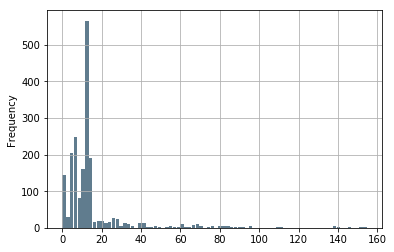

In [70]:
y_vals = new_df['SprintTE']
y_vals.plot.hist(grid=True, bins=80, rwidth=0.9,
                   color='#607c8e')
len(y_vals)

### Yikes, we do.
Let's remove datapoints from our dataset that go beyond the boundaries of the context at hand. Additionally, let's take out points that exceed 3 standard deviations from the mean. Anomaly removal is necessary for creating a useful model!

In [71]:
def out_std(s, nstd=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean
        to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
#     data_mean, data_std = s.mean(), s.std()
    data_median, data_std = s.median(), s.std()
    cut_off = data_std * nstd
#     lower, upper = data_mean - cut_off, data_mean + cut_off
    lower, upper = data_median - cut_off, data_median + cut_off
#     print (data_median, data_std)
    print (lower, upper)
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

# new_df = new_df[new_df['SprintTE']>0.25]
# new_df = new_df[new_df['SprintTE']<30]

# new_df = new_df[new_df['SprintTE']>1]
# new_df = new_df[new_df['SprintTE']<20]
# print(new_df.shape)
    
# outlier_mask = out_std(new_df['SprintTE'], nstd=3)
# print(len(outlier_mask))
# new_df['SprintTE'] = new_df['SprintTE'][~new_df['SprintTE'].isin(new_df['SprintTE'][outlier_mask])].dropna()
# new_df = new_df.dropna(subset=['SprintTE'])
# print(new_df.shape)
# new_df.reset_index(drop=True)

new_df = new_df[new_df['TotalTE']>7]
new_df = new_df[new_df['TotalTE']<100]
print(new_df.shape)
    
outlier_mask = out_std(new_df['TotalTE'], nstd=1.5)
# print(outlier_mask)
new_df['TotalTE'] = new_df['TotalTE'][~new_df['TotalTE'].isin(new_df['TotalTE'][outlier_mask])].dropna()
new_df = new_df.dropna(subset=['TotalTE'])
print(new_df.shape)
new_df.reset_index(drop=True)

(1483, 12)
-7.229904725264753 65.44101583637587
(1264, 12)


,Sprint Number,Sprint Start Date,Resolution Date,Created Date,Assignee,Sprint Points,Priority_Blocker,Priority_Critical,Priority_Medium,Priority_Minor,SprintTE,TotalTE
0,25042,2018-12-04 10:15:00,2018-12-20 08:55:00,2018-11-30 11:46:00,22,1.0,0,0,1,0,15.944444,19.881250
1,25046,2019-01-31 07:04:00,2019-02-12 14:15:00,2019-01-07 12:54:00,10,42.0,0,0,1,0,12.299306,36.056250
2,25046,2019-01-31 07:04:00,2019-02-13 09:45:00,2019-01-14 11:50:00,10,2.0,0,0,1,0,13.111806,29.913194
3,25047,2018-12-03 11:00:00,2018-12-19 10:01:00,2018-11-28 10:04:00,22,2.0,0,0,1,0,15.959028,20.997917
4,25047,2018-12-03 11:00:00,2018-12-20 09:06:00,2018-11-28 10:06:00,34,3.0,0,0,1,0,16.920833,21.958333
5,25047,2018-12-03 11:00:00,2018-12-20 09:06:00,2018-11-28 10:07:00,34,3.0,0,0,1,0,16.920833,21.957639
6,25047,2018-12-03 11:00:00,2018-12-20 09:06:00,2018-11-28 10:07:00,34,3.0,0,0,1,0,16.920833,21.957639
7,25047,2018-12-03 11:00:00,2018-12-20 09:07:00,2018-11-28 10:12:00,29,3.0,0,0,1,0,16.921528,21.954861
8,25047,2018-12-03 11:00:00,2018-12-19 11:37:00,2018-11-28 10:14:00,29,1.0,0,0,1,0,16.025694,21.057639
9,25047,2018-12-03 11:00:00,2018-12-12 07:55:00,2018-11-28 10:15:00,31,1.0,0,0,1,0,8.871528,13.902778


In [72]:
# X = new_df.drop(['Sprint Start Date', 'Resolution Date', 'Created Date', 'TotalTE', 'SprintTE'], axis=1)
# y = new_df['SprintTE']

X = new_df.drop(['Sprint Start Date', 'Resolution Date', 'Created Date', 'TotalTE', 'SprintTE'], axis=1)
y = new_df['TotalTE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print (X.shape[0] * (1-0.2))

1011.2


In [73]:
X.reset_index(drop=True)

,Sprint Number,Assignee,Sprint Points,Priority_Blocker,Priority_Critical,Priority_Medium,Priority_Minor
0,25042,22,1.0,0,0,1,0
1,25046,10,42.0,0,0,1,0
2,25046,10,2.0,0,0,1,0
3,25047,22,2.0,0,0,1,0
4,25047,34,3.0,0,0,1,0
5,25047,34,3.0,0,0,1,0
6,25047,34,3.0,0,0,1,0
7,25047,29,3.0,0,0,1,0
8,25047,29,1.0,0,0,1,0
9,25047,31,1.0,0,0,1,0


### Histogram Visualizing Distribution (After Outlier Removal)

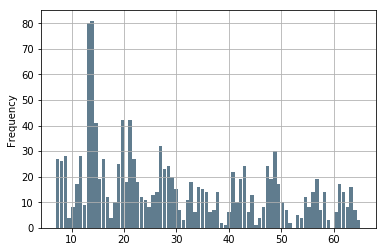

In [74]:
y.plot.hist(grid=True, bins=80, rwidth=0.9, color='#607c8e')

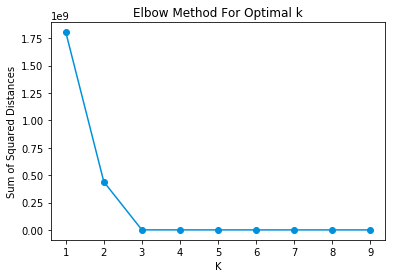

In [90]:
sum_square = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_square.append(km.inertia_)
plt.plot(K, sum_square, 'bo-', color = '#0091DA')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [76]:
num_clusters = 3

km = KMeans(n_clusters=num_clusters)
%time km.fit(X)
clusters = km.labels_.tolist()
print(len(clusters))
new_df['Cluster'] = clusters
pd.set_option('max_rows', 1800)
new_df

Wall time: 41.5 ms
1264


,Sprint Number,Sprint Start Date,Resolution Date,Created Date,Assignee,Sprint Points,Priority_Blocker,Priority_Critical,Priority_Medium,Priority_Minor,SprintTE,TotalTE,Cluster
58,25042,2018-12-04 10:15:00,2018-12-20 08:55:00,2018-11-30 11:46:00,22,1.00,0,0,1,0,15.944444,19.881250,2
160,25046,2019-01-31 07:04:00,2019-02-12 14:15:00,2019-01-07 12:54:00,10,42.00,0,0,1,0,12.299306,36.056250,2
163,25046,2019-01-31 07:04:00,2019-02-13 09:45:00,2019-01-14 11:50:00,10,2.00,0,0,1,0,13.111806,29.913194,2
166,25047,2018-12-03 11:00:00,2018-12-19 10:01:00,2018-11-28 10:04:00,22,2.00,0,0,1,0,15.959028,20.997917,2
167,25047,2018-12-03 11:00:00,2018-12-20 09:06:00,2018-11-28 10:06:00,34,3.00,0,0,1,0,16.920833,21.958333,2
168,25047,2018-12-03 11:00:00,2018-12-20 09:06:00,2018-11-28 10:07:00,34,3.00,0,0,1,0,16.920833,21.957639,2
169,25047,2018-12-03 11:00:00,2018-12-20 09:06:00,2018-11-28 10:07:00,34,3.00,0,0,1,0,16.920833,21.957639,2
170,25047,2018-12-03 11:00:00,2018-12-20 09:07:00,2018-11-28 10:12:00,29,3.00,0,0,1,0,16.921528,21.954861,2
171,25047,2018-12-03 11:00:00,2018-12-19 11:37:00,2018-11-28 10:14:00,29,1.00,0,0,1,0,16.025694,21.057639,2
172,25047,2018-12-03 11:00:00,2018-12-12 07:55:00,2018-11-28 10:15:00,31,1.00,0,0,1,0,8.871528,13.902778,2


In [77]:
def regressCluster(cluster):
#     X = cluster.drop(['Sprint Start Date', 'Resolution Date', 'Created Date', 'TotalTE', 'SprintTE'], axis=1)
#     y = cluster['SprintTE']
    
    X = cluster.drop(['Sprint Start Date', 'Resolution Date', 'Created Date', 'TotalTE', 'SprintTE', 'Cluster'], axis=1)
    y = cluster['TotalTE']
    
#     cv = KFold(n_splits=10, random_state=42, shuffle=False)
#     for train_index, test_index in cv.split(X):
#         X_train1, X_test1, y_train1, y_test1 = X[train_index], X[test_index], y[train_index], y[test_index]
#         train_test_split(X, y, test_size=0.2, random_state=2)

    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=2)
    
    #Random Forest Regressor
#     gsc = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'max_depth': range(3,7),
#                                                                       'n_estimators': (10, 50, 100, 1000)},
#                        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
#     grid_result = gsc.fit(X_train1, y_train1)
#     best_params = grid_result.best_params_
    
#     print (best_params)

#     reg = RandomForestRegressor(max_depth=best_params["max_depth"],
#                                 n_estimators=best_params["n_estimators"],
#                                 random_state=False, verbose=False)
#     reg.fit(X_train1, y_train1)
#     scores = cross_val_score(reg, X_train1, y_train1, cv=10, scoring='neg_mean_absolute_error')
#     predictions = reg.predict(X_test1)
    
    gsc = GridSearchCV(estimator=XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, alpha = 10, n_estimators= 1000, max_depth= 3), param_grid={'max_depth': range(3,7),
                                                                      'n_estimators': [10,20,30,40,50,60,70,80,100,1000]},
                       cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    grid_result = gsc.fit(X_train1, y_train1)
    best_params = grid_result.best_params_
    
    print (best_params)
    
#     XGBRegressor
    reg = XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = best_params['max_depth'], alpha = 10, n_estimators = best_params['n_estimators'])
    reg.fit(X_train1, y_train1)
    
    scores = cross_val_score(reg, X_train1, y_train1, cv = 10)
    print ("CV Score (Average) = " + str(np.mean(scores)))
    
    predictions = reg.predict(X_test1)
#     predictions = cross_val_predict(reg, X_test1, y_test1, cv = 10)

    train_error = abs(predictions-y_train1)
    print('Mean Absolute Error (Train):', round(np.mean(train_error), 2), 'degrees.')
    
    errors = abs(predictions - y_test1)
    print('Mean Absolute Error (Test):', round(np.mean(errors), 2), 'degrees.')
    
#     print ("score: " + reg.score(X_test1, y_test1))
    

#     SS_Residual = sum((errors)**2)
#     SS_Total = sum((y_test1 - np.mean(y_test1))**2)
#     r_squared = 1- (float(SS_Residual))/SS_Total
#     adjusted_r_squared = 1- (1-r_squared)*(len(y_test1)-1)/(len(y_test1)-X_test1.shape[1]-1)
#     print (f"R_Squared{r_squared}, Adjusted R_Squared{adjusted_r_squared}")
    
    prediction = pd.DataFrame({"Actual": y_test1, 'Predicted':predictions, 'Test Error':abs(((predictions-y_test1)/y_test1*100))})
    return prediction, reg

In [78]:
# def regressCluster(cluster):
#     X = cluster.drop(['Sprint Start Date', 'Resolution Date', 'Created Date', 'TotalTE', 'SprintTE', 'Cluster'], axis=1)
#     y = cluster['TotalTE']
#     k = 10
#     cv = KFold(n_splits=k, random_state=42, shuffle=False)
#     scores = []
#     predictions = np.zeros(int(X.shape[0]* (1-(1/k))))
#     for train_index, test_index in cv.split(X):
#         prediction = []
#         X_train1, X_test1, y_train1, y_test1 = X[train_index], X[test_index], y[train_index], y[test_index]
#         gsc = GridSearchCV(estimator=XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, alpha = 10, n_estimators= 1000, max_depth= 3), param_grid={'max_depth': range(3,7),
#                                                                       'n_estimators': [10,20,30,40,50,60,70,80,100,1000]},
#                        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
#         grid_result = gsc.fit(X_train1, y_train1)
#         best_params = grid_result.best_params_
#         reg = XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = best_params['max_depth'], alpha = 10, n_estimators = best_params['n_estimators'])
#         reg.fit(X_train1, y_train1)
#         prediction = reg.predict(X_test1)
#         print (type(prediction))
#         scores.append(reg.score(X_test1, y_test1))
# #         prediction = np.array(prediction)
#         predictions += prediction

In [79]:
cluster_predictions = []
models = []
for i in range(0, num_clusters):
    temp_cluster = new_df[new_df['Cluster']==i]
    prediction, model = regressCluster(temp_cluster)
    cluster_predictions.append(prediction)
    models.append(model)
    
result = pd.concat([cluster for cluster in cluster_predictions])

{'max_depth': 6, 'n_estimators': 1000}
CV Score (Average) = 0.3325284018984712


ValueError: operands could not be broadcast together with shapes (85,) (337,) 

In [ ]:
result

In [ ]:
import math
result.describe()

In [ ]:
result['Test Error'].median()

In [ ]:
score = r2_score(result['Actual'], result['Predicted'])

errors = abs(result['Actual'] - result['Predicted'])
SS_Residual = sum((errors)**2)
SS_Total = sum((result['Actual'] - np.mean(result['Actual']))**2)
r_squared = 1- (float(SS_Residual))/SS_Total
adjusted_r_squared = 1- (1-r_squared)*(len(result['Actual'])-1)/(len(result['Actual'])-X.shape[1]-1)
print (f"R_Squared: {score}, Adjusted R_Squared: {adjusted_r_squared}")

In [ ]:
result = result.sort_values('Actual')

In [ ]:
result = result.reset_index(drop=True)
result

In [ ]:
result['index1'] = result.index
result.plot(x = 'index1', y=['Actual', 'Predicted'])
plt.xlabel('Index of Story')
plt.ylabel('Number of Days')
plt.title('Index vs. Days')
plt.show()

In [ ]:
result.plot(x = 'index1', y=['Test Error'])
plt.xlabel('Index of Story')
plt.ylabel('Error')
plt.title('Index vs. Error')
plt.show()

In [ ]:
# for model in models:
#     test_input = pd.dataframe([''])
